In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import STL
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset
from scipy.fftpack import fft, ifft
import matplotlib.pyplot as plt
import seaborn as sns
import os
from datetime import datetime
from typing import Optional, Union, List, Tuple

import warnings

warnings.filterwarnings(action='ignore')

In [2]:
# 'prst_no':[ 70233,  70745,  90527, 110085, 120752, 170067, 190564, 210671]
# 'item_cd':[ 8801858011024, 88002798 ]

## 데이터 전처리 영역

In [3]:
df = pd.read_csv('서울경기.csv', )

In [4]:
df = df.drop(columns='Unnamed: 0')
item_mst = pd.read_csv('ITEM_MST.txt', sep='|', encoding='cp949')

In [5]:
# 지점별, 아이템 코드별 그룹화
grouped = df.groupby(['PRST_NO', 'ITEM_CD'])

# ADI와 CV 계산 함수
def calculate_adi_cv(group):
    demand_periods = group['SALE_QTY'].ne(0).sum()
    total_periods = len(group)
    adi = total_periods / demand_periods if demand_periods != 0 else np.inf
    cv = group['SALE_QTY'].std() / group['SALE_QTY'].mean() if group['SALE_QTY'].mean() != 0 else np.inf
    return pd.Series({'ADI': adi, 'CV': cv})

In [6]:
# ADI와 CV 계산 / cv 0.49 기준
adi_cv = grouped.apply(calculate_adi_cv).reset_index()

# 수요 패턴 분류 함수
def classify_demand_pattern(row):
    if row['ADI'] > 1.32 and row['CV'] > 0.49:
        return 'lumpy'
    elif row['ADI'] > 1.32 and row['CV'] <= 0.49:
        return 'intermittent'
    elif row['ADI'] <= 1.32 and row['CV'] > 0.49:
        return 'erratic'
    else:
        return 'smooth'


In [7]:
# 수요 패턴 분류
adi_cv['Demand_Pattern'] = adi_cv.apply(classify_demand_pattern, axis=1)

In [8]:
adi_cv[(adi_cv['Demand_Pattern']=='lumpy') & (adi_cv['ADI']<=1.5)]

,PRST_NO,ITEM_CD,ADI,CV,Demand_Pattern
46,70233,4901004006813,1.487805,1.056025,lumpy
112,70233,8801019306495,1.410405,0.965367,lumpy
230,70233,8801043036078,1.394286,0.909828,lumpy
280,70233,8801056175955,1.326087,1.014441,lumpy
282,70233,8801056177584,1.478788,1.047173,lumpy
391,70233,8801094013004,1.333333,0.926856,lumpy
404,70233,8801094082604,1.398281,1.121870,lumpy
422,70233,8801094503000,1.322493,0.995997,lumpy
553,70233,8801117446901,1.478788,0.968809,lumpy
577,70233,8801119241511,1.336986,0.987744,lumpy


In [9]:
df = df.merge(adi_cv, how='left', on=['PRST_NO', 'ITEM_CD'])

In [10]:
df = df.drop(columns='Demand_Pattern')

### 입력 파라미터 설정

In [11]:
# origin
param_dict = {
    'file_name':"서울경기.csv",
    'promotion_file_name':'promotion_[ITEM_CD, YMD_CD]_left_join.csv',
    'prst_no':[ 70233 ],
    'item_cd':[ 4901004006813 ],
    'seq_length':7, 
    # Moving Average를 할 경우 기간 설정 -> 'MA' 컬럼 생성
    # 'ma':7,
    # 예측의 입력값(X)으로 넣을 features
    'features':['monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday', 'sunday', 
            'WEEKDAY', 'FRIDAY', 'HOLIDAY', 
            # 'SALE_QTY_lag1', 'SALE_QTY_lag2', 'SALE_QTY_lag3', 'SALE_QTY_lag4', 'SALE_QTY_lag5', 'SALE_QTY_lag6', 'SALE_QTY_lag7',
            'EVT_GIVE', 'EVT_DISCOUNT', 'EVT_PLUS', 'EVT_APP',
            # 위의 'ma'를 넣었을 경우 'MA' 컬럼이 생성됨
            # 'MA', # 'DIFF', 
            ],
    'criterion' : 'mae',
    'optimizer':'adam',
    'lr' : 0.01,
    'batch_size':32,
    'model_hparams':{
        'hidden_size':64,
        'num_layers':2,
        'output_size':1,
        'learning_rate':0.001,
        'num_epochs':100
    },
    # 95 = ( 1, 5, 19, 95 )
    'lead_time':95
}

In [12]:
# # test / adi, cv
# param_dict = {
#     'file_name':"서울경기.csv",
#     'promotion_file_name':'promotion_[ITEM_CD, YMD_CD]_left_join.csv',
#     'prst_no':[ 70233 ],
#     'item_cd':[ 8801062247431 ],
#     'seq_length':7, 
#     # Moving Average를 할 경우 기간 설정 -> 'MA' 컬럼 생성
#     # 'ma':7,
#     # 예측의 입력값(X)으로 넣을 features
#     'features':['monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday', 'sunday', 
#             'WEEKDAY', 'FRIDAY', 'HOLIDAY', 'ADI', 'CV',
#             # 'SALE_QTY_lag1', 'SALE_QTY_lag2', 'SALE_QTY_lag3', 'SALE_QTY_lag4', 'SALE_QTY_lag5', 'SALE_QTY_lag6', 'SALE_QTY_lag7',
#             'EVT_GIVE', 'EVT_DISCOUNT', 'EVT_PLUS', 'EVT_APP',
#             # 위의 'ma'를 넣었을 경우 'MA' 컬럼이 생성됨
#             # 'MA', # 'DIFF', 
#             ],
#     'criterion' : 'mae',
#     'optimizer':'adam',
#     'lr' : 0.01,
#     'batch_size':32,
#     'model_hparams':{
#         'hidden_size':64,
#         'num_layers':2,
#         'output_size':1,
#         'learning_rate':0.001,
#         'num_epochs':100
#     },
#     # 95 = ( 1, 5, 19, 95 )
#     'lead_time':95

#     }

### LSTM model 클래스

In [13]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        output, (h_n, c_n) = self.lstm(x, (h_0, c_0))
        h_n = h_n[-1, :, :]
        out = self.fc(h_n)
        return out

### 처리 함수들

In [14]:
def filtering_df(
    origin_df:pd.DataFrame, 
    prst_no:Optional[List[int]], 
    item_cd:Optional[List[int]]
    )->pd.DataFrame:
    '''
    데이터프레임 필터링 함수.

    주어진 데이터프레임에서 'PRST_NO'와 'ITEM_CD' 열을 기준으로 필터링.
    두 기준이 모두 주어지면 AND 조건으로 필터링하고, 하나만 주어지면 해당 기준으로 필터링.
    기준이 주어지지 않으면 원본 데이터프레임을 반환.

    Args:
    - origin_df (pd.DataFrame): 필터링할 원본 데이터프레임.
    - prst_no (Optional[List[int]]): 'PRST_NO' 열에서 필터링할 값들의 리스트. 선택적 매개변수.
    - item_cd (Optional[List[int]]): 'ITEM_CD' 열에서 필터링할 값들의 리스트. 선택적 매개변수.

    Returns:
    - pd.DataFrame: 필터링된 데이터프레임
    '''
    if prst_no is None and item_cd is None:
        return origin_df
    if (prst_no is not None) and (item_cd is not None):
        filtered_df = origin_df[(origin_df['PRST_NO'].isin(prst_no))&(origin_df['ITEM_CD'].isin(item_cd))]
    elif prst_no is not None:
        filtered_df = origin_df[origin_df['PRST_NO'].isin(prst_no)]
    elif item_cd is not None:
        filtered_df = origin_df[origin_df['ITEM_CD'].isin(item_cd)]
    return filtered_df

In [15]:
def create_sequences(
    data:pd.DataFrame, 
    features:List[str], 
    target_column:List[str], 
    seq_length:int)->Tuple[np.array, np.array, MinMaxScaler]:
    '''
    주어진 데이터를 시계열 시퀀스로 변환하는 함수.

    이 함수는 입력된 데이터 프레임에서 특정 특징 열들을 선택하고,
    이를 정규화한 후 지정된 시퀀스 길이만큼의 시계열 데이터를 생성.
    생성된 시퀀스 데이터와 해당 타겟 값을 반환.

    Args:
    - data (pd.DataFrame): 시계열 데이터가 포함된 데이터 프레임.
    - features (List[str]): 시퀀스를 생성할 특징 열들의 리스트.
    - target_column (List[str]): 타겟 값을 포함하는 열의 리스트.
    - seq_length (int): 시퀀스의 길이.

    Returns:
    - tuple[np.array, np.array, MinMaxScaler]: 
        - 시퀀스 데이터를 포함한 numpy 배열.
        - 타겟 값을 포함한 numpy 배열.
        - 특징 열들을 정규화하기 위해 사용된 MinMaxScaler 객체.
    '''
    scaler = MinMaxScaler()
    data[features] = scaler.fit_transform(data[features])
    sequences = []
    targets = []

    for i in range(seq_length, len(data)):
        sequence = data.iloc[i - seq_length:i][features].values.astype(np.float32)
        target = data.iloc[i][target_column].astype(np.float32)
        sequences.append(sequence)
        targets.append(target)
    
    return np.array(sequences), np.array(targets).astype(np.float32), scaler

In [16]:
def aggregate_by_lead_time(
    data: np.ndarray, 
    lead_time: int)->np.ndarray:
    '''
    데이터를 리드 타임 단위로 묶어 합계를 계산하는 함수.

    이 함수는 주어진 데이터를 지정된 리드 타임 크기로 묶어 각 묶음의 합계를 계산.
    계산된 합계들을 포함하는 numpy 배열을 반환.

    Args:
    - data (np.ndarray): 합계를 계산할 숫자 데이터가 포함된 numpy 배열.
    - lead_time (int): 데이터를 묶을 크기.

    Returns:
    - np.ndarray: 각 리드 타임 묶음의 합계를 포함하는 numpy 배열.
    '''
    aggregated_data = []
    for i in range(0, len(data), lead_time):
        aggregated_data.append(np.sum(data[i:i + lead_time]))
    return np.array(aggregated_data)

### 데이터 처리

In [17]:
features = param_dict.get("features", ['monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday', 'sunday', \
    'WEEKDAY', 'FRIDAY', 'HOLIDAY', \
    'EVT_GIVE', 'EVT_DISCOUNT', 'EVT_PLUS', 'EVT_APP'])

targets = ['SALE_QTY']

In [18]:
model_hparams = param_dict.get('model_hparams',{
    'hidden_size':64,
    'num_layers':2,
    'output_size':1,
    'num_epochs':200,
    'batch_size':16
})

In [19]:
origin_df = pd.read_csv(param_dict['file_name'], parse_dates=['YMD_CD'], index_col=0)
promotion_df = pd.read_csv(param_dict['promotion_file_name'], parse_dates=['YMD_CD'])

In [20]:
filtered_df = filtering_df(origin_df, prst_no=param_dict['prst_no'], item_cd=param_dict['item_cd'])
filtered_df.shape

(488, 22)

In [21]:
merged_df = pd.merge(left=filtered_df, right=promotion_df, on=['ITEM_CD', 'YMD_CD'], how='left').fillna(0)

In [22]:
week_dict = {
    'day_0':"monday", 
    'day_1':"tuesday", 
    'day_2':"wednesday", 
    'day_3':"thursday", 
    'day_4':"friday", 
    'day_5':"saturday", 
    'day_6':"sunday"
}
merged_df.rename(columns=week_dict, inplace=True)

In [23]:
window_size = param_dict.get('ma', None)
if window_size:
    merged_df['MA'] = merged_df['SALE_QTY_lag1'].rolling(window=window_size, center=False).mean()

In [24]:
target_scaler = MinMaxScaler()
merged_df[['SALE_QTY']] = target_scaler.fit_transform(merged_df[['SALE_QTY']])

In [25]:
merged_df = merged_df.merge(adi_cv, how='left', on=['PRST_NO', 'ITEM_CD'])

### 텐서 변환

In [26]:
seq_length = param_dict.get("seq_length", 7)

In [27]:
X, y, scaler = create_sequences(merged_df, features, 'SALE_QTY', seq_length)

In [28]:
# shape check
# X.shape = (days, seq_length, num_of_features)
assert (X.shape[1]==seq_length) and (X.shape[2]==len(features))

In [29]:
# split train & test set by 'YMD_CD' time(train: 2023, test: 2024)
train_start_index = merged_df[merged_df['YMD_CD'].dt.year == 2023].index[0] - seq_length
train_end_index = merged_df[merged_df['YMD_CD'].dt.year == 2023].index[-1] - seq_length + 1
test_start_index = merged_df[merged_df['YMD_CD'].dt.year == 2024].index[0] - seq_length
X_train, y_train = X[train_start_index:train_end_index], y[train_start_index:train_end_index]
X_test, y_test = X[test_start_index:], y[test_start_index:]

In [30]:
# shape check
# X_train   = (2023 days: 365,  seq_length, num_of_features)
# X_test    = (2024 days: 95,   seq_length, num_of_features)
assert (X_train.shape[0]==y_train.shape[0]==365) and (X_test.shape[0]==y_test.shape[0]==filtered_df[filtered_df['YMD_CD'].dt.year==2024].shape[0])

In [31]:
X_train_tensors = torch.Tensor(X_train)
y_train_tensors = torch.Tensor(y_train).unsqueeze(1)
X_test_tensors = torch.Tensor(X_test)
y_test_tensors = torch.Tensor(y_test).unsqueeze(1)

In [32]:
input_size = X_train_tensors.shape[2]

In [33]:
train_dataset = TensorDataset(X_train_tensors, y_train_tensors)
train_loader = DataLoader(train_dataset, batch_size=param_dict.get('batch_size', 16), shuffle=True)

### 모델링 시작

In [34]:
# device setting
# cuda gpu
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"Using CUDA device:{torch.cuda.get_device_name(0)}")
# apple gpu(mps)
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using MPS device")
# cpu
else:
    device = torch.device("cpu")
    print("Using CPU device")

Using MPS device


In [35]:
# init model
model = LSTM(input_size, model_hparams['hidden_size'], model_hparams['num_layers'], model_hparams['output_size']).to(device)

In [36]:
# 손실 함수와 옵티마이저 정의
criterion_dict = {
    'mse':nn.MSELoss,
    'mae':nn.L1Loss
    }

criterion_option = param_dict.get('criterion', 'mae')
lr = param_dict.get('lr', 0.01)
criterion = criterion_dict[criterion_option]()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

### 모델 학습

In [37]:
# origin
train_losses = []
val_losses = []
num_epochs = model_hparams.get("num_epochs", 200)

for epoch in range(num_epochs):
    model.train()
    epoch_train_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        
        epoch_train_loss += loss.item()
    
    train_losses.append(epoch_train_loss / len(train_loader))
    
    # evaluation by test set
    model.eval()
    with torch.no_grad():
        outputs = model(X_test_tensors.to(device))
        val_loss = criterion(outputs, y_test_tensors.to(device)).item()
        val_losses.append(val_loss)
    
    if epoch % 10 == 0:
        print(f'Epoch {epoch}/{num_epochs}, Train Loss: {epoch_train_loss / len(train_loader):.4f}, Validation Loss: {val_loss:.4f}')

Epoch 0/100, Train Loss: 0.1695, Validation Loss: 0.1731
Epoch 10/100, Train Loss: 0.1587, Validation Loss: 0.1685
Epoch 20/100, Train Loss: 0.1593, Validation Loss: 0.1755
Epoch 30/100, Train Loss: 0.1530, Validation Loss: 0.1808
Epoch 40/100, Train Loss: 0.1460, Validation Loss: 0.1929
Epoch 50/100, Train Loss: 0.1455, Validation Loss: 0.1820
Epoch 60/100, Train Loss: 0.1427, Validation Loss: 0.1795
Epoch 70/100, Train Loss: 0.1376, Validation Loss: 0.1848
Epoch 80/100, Train Loss: 0.1377, Validation Loss: 0.1849
Epoch 90/100, Train Loss: 0.1382, Validation Loss: 0.1889


In [38]:
# # test
# train_losses = []
# val_losses = []
# num_epochs = model_hparams.get("num_epochs", 200)

# for epoch in range(num_epochs):
#     model.train()
#     epoch_train_loss = 0
#     for X_batch, y_batch in train_loader:
#         X_batch = X_batch.to(device)
#         y_batch = y_batch.to(device)
        
#         optimizer.zero_grad()
#         outputs = model(X_batch)
#         loss = criterion(outputs, y_batch)
#         loss.backward()
#         optimizer.step()
        
#         epoch_train_loss += loss.item()
    
#     train_losses.append(epoch_train_loss / len(train_loader))
    
#     # evaluation by test set
#     model.eval()
#     with torch.no_grad():
#         outputs = model(X_test_tensors.to(device))
#         val_loss = criterion(outputs, y_test_tensors.to(device)).item()
#         val_losses.append(val_loss)
    
#     if epoch % 10 == 0:
#         print(f'Epoch {epoch}/{num_epochs}, Train Loss: {epoch_train_loss / len(train_loader):.4f}, Validation Loss: {val_loss:.4f}')

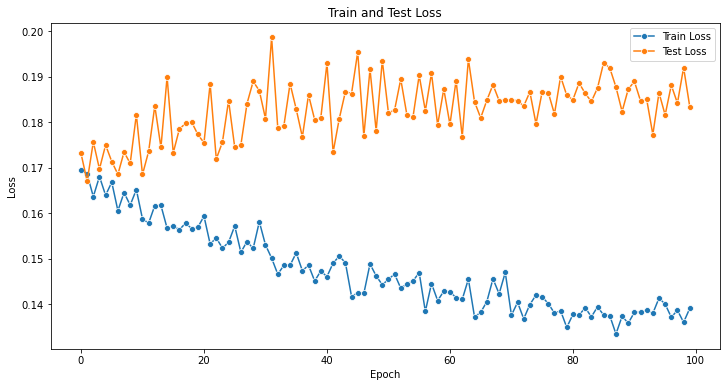

In [39]:
# origin
plt.figure(figsize=(12, 6))
sns.lineplot(x=range(num_epochs), y=train_losses, label='Train Loss', marker='o')
sns.lineplot(x=range(num_epochs), y=val_losses, label='Test Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Test Loss')
plt.legend()
plt.show()

In [40]:
# # test
# plt.figure(figsize=(12, 6))
# sns.lineplot(x=range(num_epochs), y=train_losses, label='Train Loss', marker='o')
# sns.lineplot(x=range(num_epochs), y=val_losses, label='Test Loss', marker='o')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.title('Train and Test Loss')
# plt.legend()
# plt.show()

In [41]:
lead_time = param_dict.get('lead_time', 14)
# lead_time = 5

### 모델 평가

MAE (predictions): 0.1834
MAE (predictions_original): 2.2011
NMAE (predictions): 0.9817
NMAE (predictions_original): 0.9817


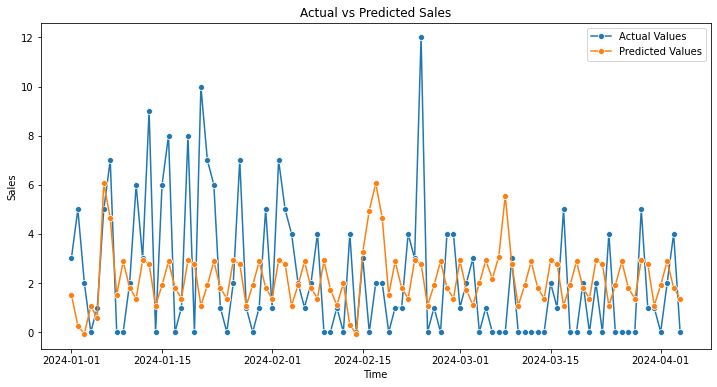

In [42]:
# origin
model.eval()
with torch.no_grad():
    X_test_tensors = X_test_tensors.to(device)
    predictions = model(X_test_tensors).cpu().numpy()

# 예측 값과 실제 값 복원
# create dummy_features
dummy_features = np.zeros((predictions.shape[0], len(features)))
# predict last day
dummy_features[:, -1] = predictions[:, 0]

predictions_original = target_scaler.inverse_transform(dummy_features)[:, -1]
y_test_original = target_scaler.inverse_transform(np.hstack((np.zeros((y_test.shape[0], len(features) - 1)), y_test.reshape(-1, 1))))[:, -1]

# MAE loss(error)
mae_predictions = mean_absolute_error(y_test, predictions)
nmae_predictions = mae_predictions / np.mean(np.abs(y_test))

mae_predictions_original = mean_absolute_error(y_test_original, predictions_original)
nmae_predictions_original = mae_predictions_original / np.mean(np.abs(y_test_original))

# MAE 출력
print(f'MAE (predictions): {mae_predictions:.4f}')
print(f'MAE (predictions_original): {mae_predictions_original:.4f}')

print(f'NMAE (predictions): {nmae_predictions:.4f}')
print(f'NMAE (predictions_original): {nmae_predictions_original:.4f}')
start_date = '2024-01-01'
end_date = '2024-04-04'
date_range = pd.date_range(start=start_date, end=end_date)
date_array = date_range.to_numpy()

plt.figure(figsize=(12, 6))
sns.lineplot(x=date_array[:lead_time], y=y_test_original[:lead_time], label='Actual Values', marker='o')
sns.lineplot(x=date_array[:lead_time], y=predictions_original[:lead_time], label='Predicted Values', marker='o')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.title('Actual vs Predicted Sales')
plt.legend()
plt.show()

In [43]:
# # test
# model.eval()
# with torch.no_grad():
#     X_test_tensors = X_test_tensors.to(device)
#     predictions = model(X_test_tensors).cpu().numpy()

# # 예측 값과 실제 값 복원
# # create dummy_features
# dummy_features = np.zeros((predictions.shape[0], len(features)))
# # predict last day
# dummy_features[:, -1] = predictions[:, 0]

# predictions_original = target_scaler.inverse_transform(dummy_features)[:, -1]
# y_test_original = target_scaler.inverse_transform(np.hstack((np.zeros((y_test.shape[0], len(features) - 1)), y_test.reshape(-1, 1))))[:, -1]

# # MAE loss(error)
# mae_predictions = mean_absolute_error(y_test, predictions)
# nmae_predictions = mae_predictions / np.mean(np.abs(y_test))

# mae_predictions_original = mean_absolute_error(y_test_original, predictions_original)
# nmae_predictions_original = mae_predictions_original / np.mean(np.abs(y_test_original))

# # MAE 출력
# print(f'MAE (predictions): {mae_predictions:.4f}')
# print(f'MAE (predictions_original): {mae_predictions_original:.4f}')

# print(f'NMAE (predictions): {nmae_predictions:.4f}')
# print(f'NMAE (predictions_original): {nmae_predictions_original:.4f}')
# start_date = '2024-01-01'
# end_date = '2024-04-04'
# date_range = pd.date_range(start=start_date, end=end_date)
# date_array = date_range.to_numpy()

# plt.figure(figsize=(12, 6))
# sns.lineplot(x=date_array[:lead_time], y=y_test_original[:lead_time], label='Actual Values', marker='o')
# sns.lineplot(x=date_array[:lead_time], y=predictions_original[:lead_time], label='Predicted Values', marker='o')
# plt.xlabel('Time')
# plt.ylabel('Sales')
# plt.title('Actual vs Predicted Sales')
# plt.legend()
# plt.show()

MAE (predictions): 0.1834
MAE (predictions_original): 2.2011
NMAE (predictions): 0.9817
NMAE (predictions_original): 0.9817


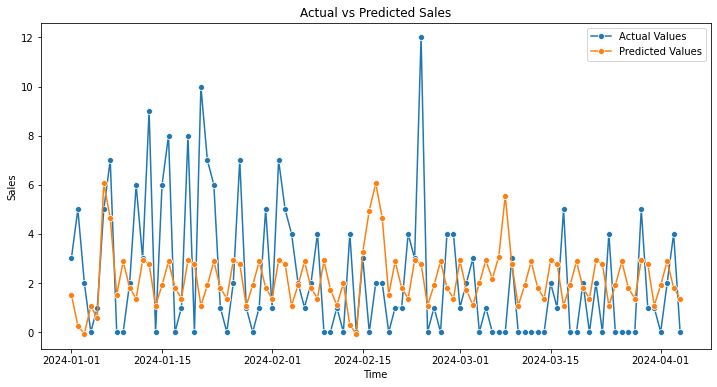

In [44]:
# model.eval()
# with torch.no_grad():
#     X_test_tensors = X_test_tensors.to(device)
#     predictions = model(X_test_tensors).cpu().numpy()

# # 예측 값과 실제 값 복원
# # create dummy_features
# dummy_features = np.zeros((predictions.shape[0], len(features)))
# # predict last day
# dummy_features[:, -1] = predictions[:, 0]

# predictions_original = target_scaler.inverse_transform(dummy_features)[:, -1]
# y_test_original = target_scaler.inverse_transform(np.hstack((np.zeros((y_test.shape[0], len(features) - 1)), y_test.reshape(-1, 1))))[:, -1]

# # MAE loss(error)
# mae_predictions = mean_absolute_error(y_test, predictions)
# nmae_predictions = mae_predictions / np.mean(np.abs(y_test))

# mae_predictions_original = mean_absolute_error(y_test_original, predictions_original)
# nmae_predictions_original = mae_predictions_original / np.mean(np.abs(y_test_original))

# # MAE 출력
# print(f'MAE (predictions): {mae_predictions:.4f}')
# print(f'MAE (predictions_original): {mae_predictions_original:.4f}')

# print(f'NMAE (predictions): {nmae_predictions:.4f}')
# print(f'NMAE (predictions_original): {nmae_predictions_original:.4f}')
# start_date = '2024-01-01'
# end_date = '2024-04-04'
# date_range = pd.date_range(start=start_date, end=end_date)
# date_array = date_range.to_numpy()

# plt.figure(figsize=(12, 6))
# sns.lineplot(x=date_array[:lead_time], y=y_test_original[:lead_time], label='Actual Values', marker='o')
# sns.lineplot(x=date_array[:lead_time], y=predictions_original[:lead_time], label='Predicted Values', marker='o')
# plt.xlabel('Time')
# plt.ylabel('Sales')
# plt.title('Actual vs Predicted Sales')
# plt.legend()
# plt.show()

MAE (aggregated): 2.2011
NMAE (aggregated): 0.9817


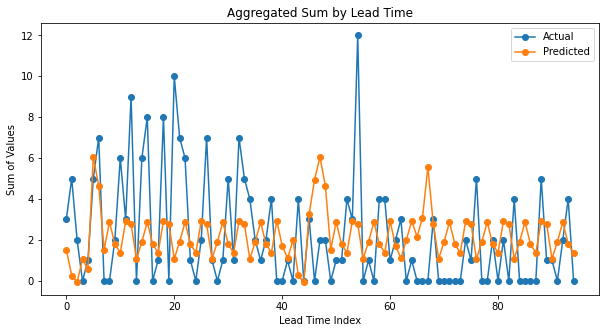

In [45]:

lead_time = 1 # 며칠씩 묶어서 예측할지 단위 입력
y_test_aggregated = aggregate_by_lead_time(y_test_original, lead_time)
predictions_aggregated = aggregate_by_lead_time(predictions_original, lead_time)

aggr_mae = mean_absolute_error(y_test_aggregated, predictions_aggregated)
print(f'MAE (aggregated): {aggr_mae:.4f}')

aggr_nmae = aggr_mae / np.mean(np.abs(y_test_aggregated))
print(f'NMAE (aggregated): {aggr_nmae:.4f}')

# 결과 시각화
plt.figure(figsize=(10, 5))
plt.plot(y_test_aggregated, label='Actual', marker='o')
plt.plot(predictions_aggregated, label='Predicted', marker='o')
plt.xlabel('Lead Time Index')
plt.ylabel('Sum of Values')
plt.title('Aggregated Sum by Lead Time')
plt.legend()
plt.show()

In [46]:
# # test
# lead_time = 1 # 며칠씩 묶어서 예측할지 단위 입력
# y_test_aggregated = aggregate_by_lead_time(y_test_original, lead_time)
# predictions_aggregated = aggregate_by_lead_time(predictions_original, lead_time)

# aggr_mae = mean_absolute_error(y_test_aggregated, predictions_aggregated)
# print(f'MAE (aggregated): {aggr_mae:.4f}')

# aggr_nmae = aggr_mae / np.mean(np.abs(y_test_aggregated))
# print(f'NMAE (aggregated): {aggr_nmae:.4f}')

# # 결과 시각화
# plt.figure(figsize=(10, 5))
# plt.plot(y_test_aggregated, label='Actual', marker='o')
# plt.plot(predictions_aggregated, label='Predicted', marker='o')
# plt.xlabel('Lead Time Index')
# plt.ylabel('Sum of Values')
# plt.title('Aggregated Sum by Lead Time')
# plt.legend()
# plt.show()